# Random Forest

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error
from scipy.stats import median_abs_deviation
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [5]:
# Load datasets and assign 'generalCategory' for coffee shops
df_coffee = pd.read_csv("final_coffeeshops_dataset_cleaned.csv")
if 'generalCategory' not in df_coffee.columns:
    df_coffee['generalCategory'] = 'coffee shop'

df_restaurant = pd.read_csv("final_restaurants_dataset_cleaned.csv")

# Unify local competition and average rating features names for both dataset
coffee_rename_map = {
    "Competition - Coffee Shops/Area": "Competition - Business Type/Area",
    "Competition - Coffee Shops/POI Density": "Competition - Business Type/POI Density",
    "Competition - Coffee Shops/related POIs": "Competition - Business Type/related POIs",
    "Avg Rating - Coffee Shops": "Avg Rating - Business Type"
}

restaurant_rename_map = {
    "Competition - Restaurants/Area": "Competition - Business Type/Area",
    "Competition - Restaurants/POI Density": "Competition - Business Type/POI Density",
    "Competition - Restaurants/related POIs": "Competition - Business Type/related POIs",
    "Avg Rating - Restaurants": "Avg Rating - Business Type"
}

df_coffee.rename(columns=coffee_rename_map, inplace=True)
df_restaurant.rename(columns=restaurant_rename_map, inplace=True)

# Combine datasets
df = pd.concat([df_coffee, df_restaurant], ignore_index=True)
#df = df_restaurant
#df = df_coffee
df['generalCategory'] = df['generalCategory'].map({'restaurant': 1, 'coffee shop': 0}).fillna(-1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Business ID                               1910 non-null   object 
 1   Name                                      1910 non-null   object 
 2   Latitude                                  1910 non-null   float64
 3   Longitude                                 1910 non-null   float64
 4   Category                                  1910 non-null   object 
 5   Rating                                    1910 non-null   object 
 6   Popularity                                1910 non-null   float64
 7   Google Place ID                           1909 non-null   object 
 8   Business Status                           1910 non-null   object 
 9   Distance (m)                              1910 non-null   float64
 10  Cluster                             

In [7]:
pd.set_option('display.max_columns', None)  # Show all columns
df

Business ID  \
0     62c4a4963e2a294ed8a25d2f   
1     5f6e3c929227c33c89239843   
2     5f97ed2d107f3c6dc6c1a5aa   
3     6032ae77fe87f20035e807ae   
4     5cae56c1911fc4002c178ee6   
...                        ...   
1905  628ba20c6b088a1a0854c680   
1906  5b12ee0ff15b51002c7b18ec   
1907  57e79d48498eebbe22491d71   
1908  643b62c16398ee2a64bbfd62   
1909  5fe0a2a792e3ef482c70e947   

                                                   Name   Latitude  Longitude  \
0                      espresso station (اسبريسو ستيشن)  26.241778  50.214466   
1                                        cesario coffee  26.255965  50.220532   
2                                              blue sky  26.254914  50.214438   
3       al-taam coffee and flour mill (مطاحن وبن التام)  26.273722  50.185155   
4                        deawaniyat gdoe (ديوانية قدوع)  26.269075  50.190190   
...                                                 ...        ...        ...   
1905                                        SALT (سولت)  26.390729  50.037699   
1906  maestro shawarma sandwich (مايسترو شاورما ساند...  26.363111  50.072717   
1907                                      Shawarma Guys  26.314099  50.147773   
1908                          Shrimp Storm (شرمب ستورم)  26.320289  50.222604   
1909                                            Nando's  26.391511  50.037390   

                   Category     Rating  Popularity  \
0               Coffee Shop        8.8    0.968299   
1               Coffee Shop        8.6    0.991283   
2               Coffee Shop  No rating    0.963778   
3               Coffee Shop  No rating    0.943726   
4               Coffee Shop  No rating    0.544394   
...                     ...        ...         ...   
1905           Burger Joint        8.9    0.997484   
1906    Shawarma Restaurant        7.6    0.965308   
1907    Shawarma Restaurant  No rating    0.725694   
1908     Seafood Restaurant  No rating    0.884345   
1909  Portuguese Restaurant        8.1    0.993612   

                  Google Place ID Business Status  Distance (m)  Cluster  \
0     ChIJAdfdZe3DST4RZa6OMkKHAik     OPERATIONAL     22.548395      NaN   
1     ChIJL8UsA0DDST4RYNisFSUqTgA     OPERATIONAL     61.034601      NaN   
2     ChIJA1rVWjjDST4RcKfC6nIvWlY     OPERATIONAL     45.840860      NaN   
3     ChIJp_j-xQfoST4RsVjm_vbAVNY     OPERATIONAL     13.973567      NaN   
4     ChIJ61O7sAPoST4RDa2oMwn0MRw     OPERATIONAL     49.435134      NaN   
...                           ...             ...           ...      ...   
1905  ChIJw1LODeH9ST4RBBBHkY2Lsb4     OPERATIONAL    165.727567      8.0   
1906  ChIJwWwZVRbjST4R3lo0ndG-iDg     OPERATIONAL      9.705615      0.0   
1907  ChIJxXIQ1mbmST4RyVDvR1R7ZB4     OPERATIONAL     23.344829      4.0   
1908  ChIJyeJClXnpST4RlGjx5fO0Cic     OPERATIONAL      9.110549      7.0   
1909  ChIJz0o3NrH9ST4RH5SCiOjz85M     OPERATIONAL     78.367921      8.0   

      generalCategory  Religious Institutions  Coffee Shops  Food & Dining  \
0                   0                       1             2              2   
1                   0                       1             2              9   
2                   0                       3             1              4   
3                   0                       1             1             14   
4                   0                       2             3             16   
...               ...                     ...           ...            ...   
1905                1                       1             4             16   
1906                1                       0             3             14   
1907                1                       0             3             16   
1908                1                       2             2              8   
1909                1                       0             2              9   

      Restaurants  Home & Construction Services  Entertainment & Recreation  \
0               1                             0            

## Data Pre-processing

In [9]:
# Drop irrelevant columns
drop_columns = ['Business ID', 'Latitude'	, 'Longitude', 'Name', 'Category', 'Rating', 'Google Place ID', 'Business Status',
                'Cluster', 'Distance (m)', 'Avg Rating - Business Type', 'Competition - Business Type/Area', 'Competition - Food & Dining/Area',
                'Competition - Business Type/POI Density', 'Competition - Food & Dining/POI Densit', 'Competition - Business Type/related POIs'
               , 'Competition - Food & Dining/POI Density']
df.drop(columns=drop_columns, inplace=True, errors='ignore')



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Popularity                                1910 non-null   float64
 1   generalCategory                           1910 non-null   int64  
 2   Religious Institutions                    1910 non-null   int64  
 3   Coffee Shops                              1910 non-null   int64  
 4   Food & Dining                             1910 non-null   int64  
 5   Restaurants                               1910 non-null   int64  
 6   Home & Construction Services              1910 non-null   int64  
 7   Entertainment & Recreation                1910 non-null   int64  
 8   Retail & Shopping                         1910 non-null   int64  
 9   Finance & Services                        1910 non-null   int64  
 10  Education                           

In [11]:
# Convert categorical columns to numeric
df = df.apply(lambda col: col.astype('category') if col.dtypes == 'object' else col)
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Popularity                                1910 non-null   float64
 1   generalCategory                           1910 non-null   int64  
 2   Religious Institutions                    1910 non-null   int64  
 3   Coffee Shops                              1910 non-null   int64  
 4   Food & Dining                             1910 non-null   int64  
 5   Restaurants                               1910 non-null   int64  
 6   Home & Construction Services              1910 non-null   int64  
 7   Entertainment & Recreation                1910 non-null   int64  
 8   Retail & Shopping                         1910 non-null   int64  
 9   Finance & Services                        1910 non-null   int64  
 10  Education                           

In [12]:
# Check for Missing Values
print("\nMissing Values Per Column:")
print(df.isnull().sum())
print("\nTotal Missing Values:", df.isnull().sum().sum())


Missing Values Per Column:
Popularity                                  0
generalCategory                             0
Religious Institutions                      0
Coffee Shops                                0
Food & Dining                               0
Restaurants                                 0
Home & Construction Services                0
Entertainment & Recreation                  0
Retail & Shopping                           0
Finance & Services                          0
Education                                   0
Health                                      0
Public & Government Services                0
Hotels & Hospitality                        0
Transportation & Travel                     0
Beauty & Wellness                           0
POI Density                                 0
Avg Rating - Food & Dining                  0
Competition - Food & Dining/related POIs    0
Population Within 1km                       0
dtype: int64

Total Missing Values: 0


In [13]:
#Test each competition factor separately and output the results to help you identify which one gives the best performance.
competition_columns = [
    'Competition - Business Type/Area',
    'Competition - Business Type/POI Density',
    'Competition - Business Type/related POIs',
    'Competition - Food & Dining/Area',
    'Competition - Food & Dining/POI Density',
    'Competition - Food & Dining/related POIs'
]

In [14]:
# Helper Functions to remove outliers and highly correlated features

def remove_outliers(X, y):
    """Remove outliers using IQR."""
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (y >= lower_bound) & (y <= upper_bound)
    return X[mask], y[mask]

    
# Remove Highly Correlated Features (Modified)
removed_corr_features = []  # List to store removed features

def remove_highly_correlated_features(X, threshold=0.95):
    """Removes highly correlated features from X."""
    corr_matrix = X.corr().abs()  # Compute absolute correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle

    # Find columns to drop
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return X.drop(columns=to_drop, errors='ignore'), to_drop  # Drop and return removed features

In [15]:
df

Popularity  generalCategory  Religious Institutions  Coffee Shops  \
0       0.968299                0                       1             2   
1       0.991283                0                       1             2   
2       0.963778                0                       3             1   
3       0.943726                0                       1             1   
4       0.544394                0                       2             3   
...          ...              ...                     ...           ...   
1905    0.997484                1                       1             4   
1906    0.965308                1                       0             3   
1907    0.725694                1                       0             3   
1908    0.884345                1                       2             2   
1909    0.993612                1                       0             2   

      Food & Dining  Restaurants  Home & Construction Services  \
0                 2            1                             0   
1                 9            8                             0   
2                 4            3                             0   
3                14           13                             0   
4                16           13                             0   
...             ...          ...                           ...   
1905             16           11                             0   
1906             14           10                             0   
1907             16           13                             0   
1908              8            6                             0   
1909              9            6                             0   

      Entertainment & Recreation  Retail & Shopping  Finance & Services  \
0                              0                  5                   0   
1                              3                  4                   2   
2                              0                  3                   2   
3                              0                 18                   4   
4                              0                  8                   6   
...                          ...                ...                 ...   
1905                           2                 39                   0   
1906                           0                 21                   5   
1907                           1                  4                   4   
1908                           3                  9                   3   
1909                           0                 46                   2   

      Education  Health  Public & Government Services  Hotels & Hospitality  \
0             0       0                             0                     0   
1             0       0                             0                     0   
2             2       0                             1                     0   
3             0       2                             0                     3   
4             0       2                             0                     7   
...         ...     ...                           ...                   ...   
1905          1       2                             0                     0   
1906          1       3                             1                     3   
1907          2       1                             2                     1   
1908          1       3                             1                     2   
1909          1       1                             0                     0   

      Transportation & Travel  Beauty & Wellness  POI Density  \
0                          14                  1           58   
1                           3                  1           56   
2                           3                  1           57   
3                           1                  6           58   
4                           2                  5           58   
...                       ...                ...          ...   
1905   

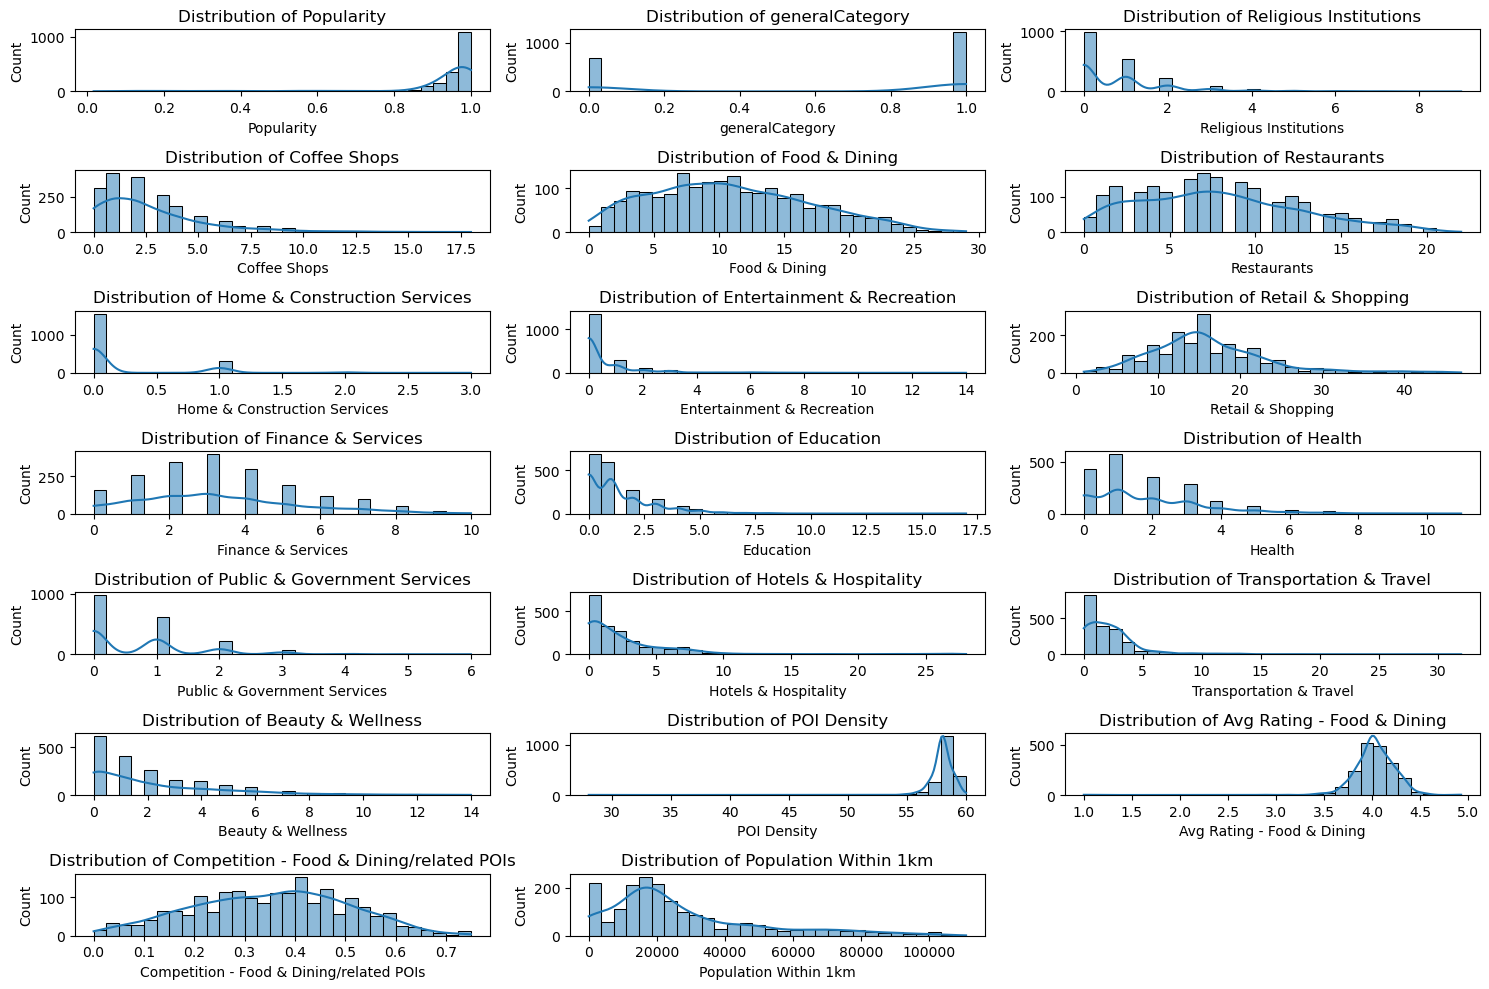

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the distribution of all features in a DataFrame
def plot_feature_distributions(df):
    num_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns
    
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot((len(num_cols) // 3) + 1, 3, i)  # Create subplots with 3 columns
        sns.histplot(df[col], kde=True, bins=30)  # Histogram with KDE
        plt.title(f'Distribution of {col}')
    
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
plot_feature_distributions(df)


<class 'pandas.core.frame.DataFrame'>
Index: 1709 entries, 0 to 1909
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Popularity                                1709 non-null   float64
 1   generalCategory                           1709 non-null   int64  
 2   Religious Institutions                    1709 non-null   int64  
 3   Coffee Shops                              1709 non-null   int64  
 4   Food & Dining                             1709 non-null   int64  
 5   Restaurants                               1709 non-null   int64  
 6   Home & Construction Services              1709 non-null   int64  
 7   Entertainment & Recreation                1709 non-null   int64  
 8   Retail & Shopping                         1709 non-null   int64  
 9   Finance & Services                        1709 non-null   int64  
 10  Education                                

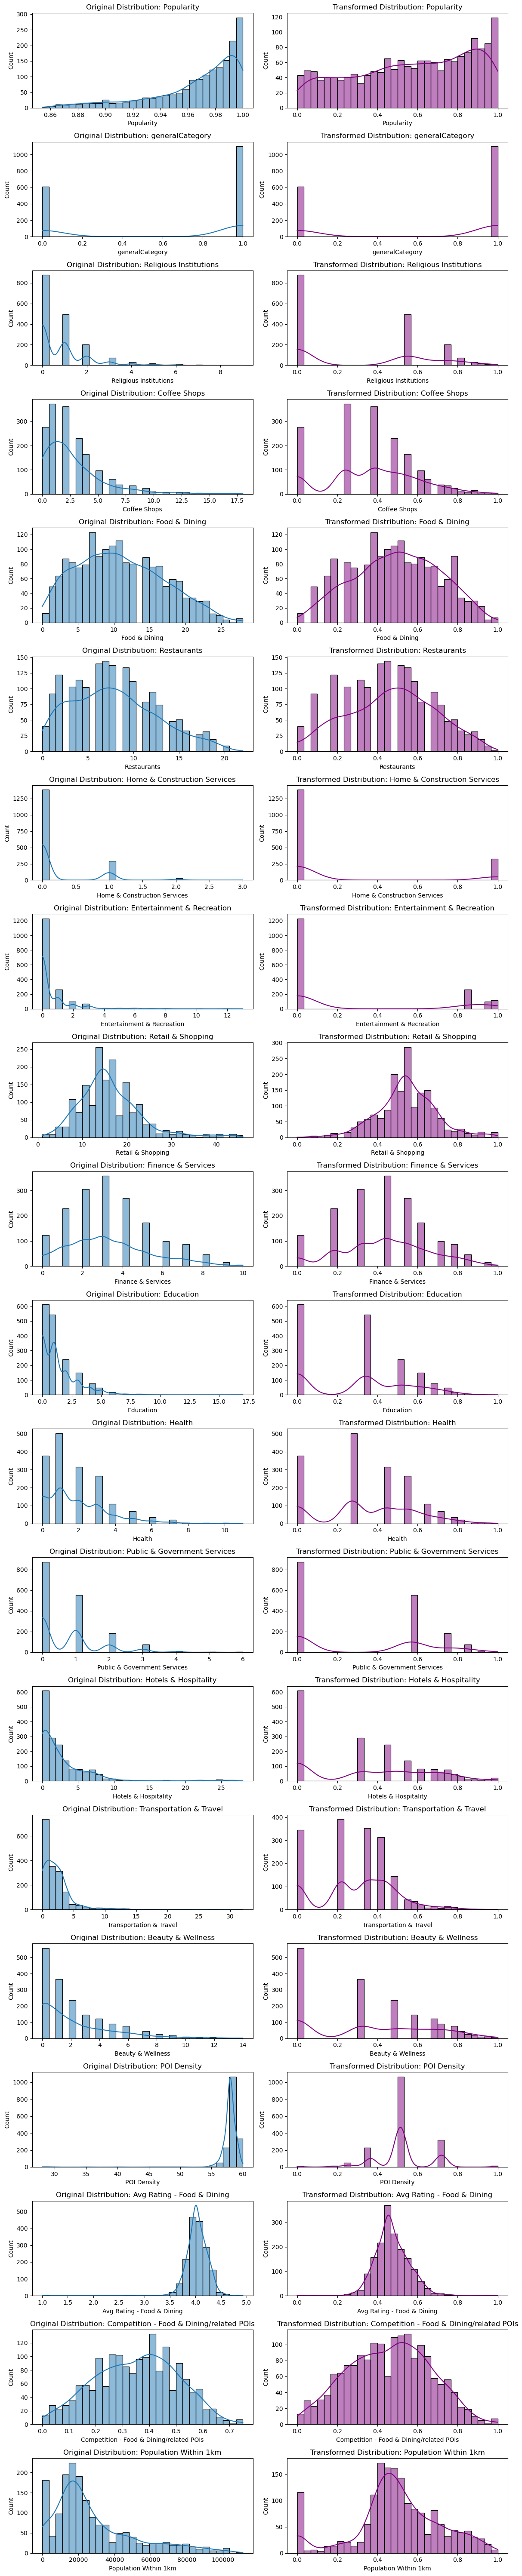


Shapiro-Wilk Normality Test Results:
                                         Shapiro-Wilk Test Statistic p-value  \
Popularity                                                  0.941258     0.0   
generalCategory                                             0.605886     0.0   
Religious Institutions                                      0.760322     0.0   
Coffee Shops                                                0.948158     0.0   
Food & Dining                                               0.986557     0.0   
Restaurants                                                  0.98381     0.0   
Home & Construction Services                                0.479157     0.0   
Entertainment & Recreation                                  0.584778     0.0   
Retail & Shopping                                           0.985463     0.0   
Finance & Services                                          0.967702     0.0   
Education                                                   0.859348     0.0   
He

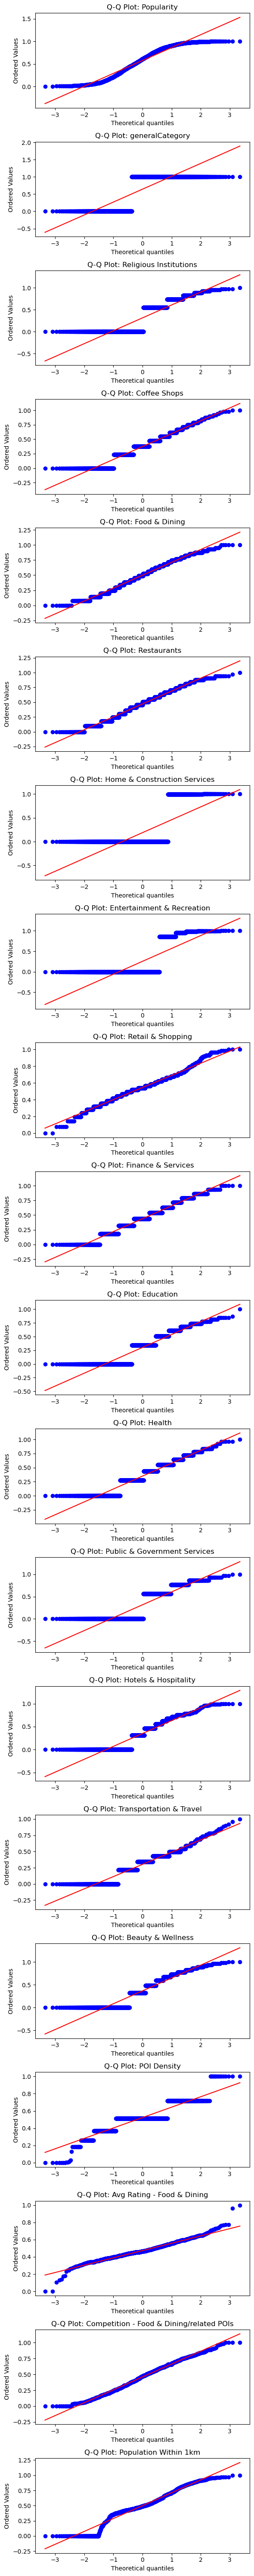

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# Copy DataFrame
transformed_df = df.copy()

# Remove outliers in 'Popularity' using IQR method
Q1 = transformed_df['Popularity'].quantile(0.25)
Q3 = transformed_df['Popularity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
transformed_df = transformed_df[(transformed_df['Popularity'] >= lower_bound) & (transformed_df['Popularity'] <= upper_bound)]

transformed_df.info()
# Select numerical columns
num_cols = transformed_df.select_dtypes(include=['number']).columns

# Store original distributions before transformation
original_distributions = transformed_df[num_cols].copy()

# Apply PowerTransformer (normalize distribution)
power_transformer = PowerTransformer()
transformed_df[num_cols] = power_transformer.fit_transform(transformed_df[num_cols])

# Apply MinMaxScaler (scale to 0-1)
minmax_scaler = MinMaxScaler()
transformed_df[num_cols] = minmax_scaler.fit_transform(transformed_df[num_cols])

# Plot before and after transformation distributions
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(12, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    # Original distribution
    sns.histplot(original_distributions[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original Distribution: {col}')
    
    # Transformed distribution
    sns.histplot(transformed_df[col], kde=True, bins=30, ax=axes[i, 1], color='purple')
    axes[i, 1].set_title(f'Transformed Distribution: {col}')

plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test for normality on each transformed feature
normality_results = {}
for col in num_cols:
    shapiro_test_stat, shapiro_p_value = shapiro(transformed_df[col])
    normality_results[col] = {
        "Shapiro-Wilk Test Statistic": shapiro_test_stat,
        "p-value": shapiro_p_value,
        "Normality": "Yes" if shapiro_p_value > 0.05 else "No"
    }

# Convert results to DataFrame
normality_df = pd.DataFrame(normality_results).T

# Display normality test results
print("\nShapiro-Wilk Normality Test Results:")
print(normality_df)

# Optionally, save results to a CSV file
normality_df.to_csv("normality_test_results.csv", index=True)

# Q-Q Plots for each transformed feature
fig, axes = plt.subplots(nrows=len(num_cols), figsize=(6, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    probplot(transformed_df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {col}")

plt.tight_layout()
plt.show()

In [18]:
transformed_df

Popularity  generalCategory  Religious Institutions  Coffee Shops  \
0       0.488228              0.0                0.547498      0.375711   
1       0.824356              0.0                0.547498      0.375711   
2       0.439074              0.0                0.827586      0.237409   
3       0.269607              0.0                0.547498      0.237409   
5       0.530464              0.0                0.000000      0.375711   
...          ...              ...                     ...           ...   
1904    0.286009              1.0                0.000000      0.000000   
1905    0.946105              1.0                0.547498      0.549351   
1906    0.455188              1.0                0.000000      0.473582   
1908    0.041665              1.0                0.733496      0.375711   
1909    0.868270              1.0                0.000000      0.375711   

      Food & Dining  Restaurants  Home & Construction Services  \
0          0.142920     0.098024                           0.0   
1          0.456153     0.503760                           0.0   
2          0.249018     0.243172                           0.0   
3          0.623725     0.704951                           0.0   
5          0.295463     0.303394                           0.0   
...             ...          ...                           ...   
1904       0.824106     0.908385                           0.0   
1905       0.684226     0.628975                           0.0   
1906       0.623725     0.588929                           0.0   
1908       0.418870     0.409882                           0.0   
1909       0.456153     0.409882                           0.0   

      Entertainment & Recreation  Retail & Shopping  Finance & Services  \
0                       0.000000           0.241140            0.000000   
1                       0.980769           0.195027            0.320728   
2                       0.000000           0.142134            0.320728   
3                       0.000000           0.604188            0.538544   
5                       0.000000           0.541205            0.320728   
...                          ...                ...                 ...   
1904                    0.000000           0.469589            0.320728   
1905                    0.955878           0.920867            0.000000   
1906                    0.000000           0.660729            0.630221   
1908                    0.980769           0.385651            0.436772   
1909                    0.000000           1.000000            0.320728   

      Education    Health  Public & Government Services  Hotels & Hospitality  \
0      0.000000  0.000000                      0.000000              0.000000   
1      0.000000  0.000000                      0.000000              0.000000   
2      0.504529  0.000000                      0.566893              0.000000   
3      0.000000  0.434798                      0.000000              0.559163   
5      0.000000  0.272997                      0.000000              0.750045   
...         ...       ...                           ...                   ...   
1904   0.679460  0.778020                      0.865619              0.314247   
1905   0.340985  0.434798                      0.000000              0.000000   
1906   0.340985  0.550553                      0.566893              0.559163   
1908   0.340985  0.550553                      0.566893              0.464863   
1909   0.340985  0.272997                      0.000000              0.000000   

      Transportation & Travel  Beauty & Wellness  POI Density  \
0                    0.796420           0.321596     0.514776   
1                    0.427495           0.321596     0.258995   
2                    0.427495           0.321596     0.366219   
3                    0.219197           0.781545     0.514776   
5                    0.427495           0.321596     0.514776   
...                       ...                ...

## Features Analysis

### Feature Correlation

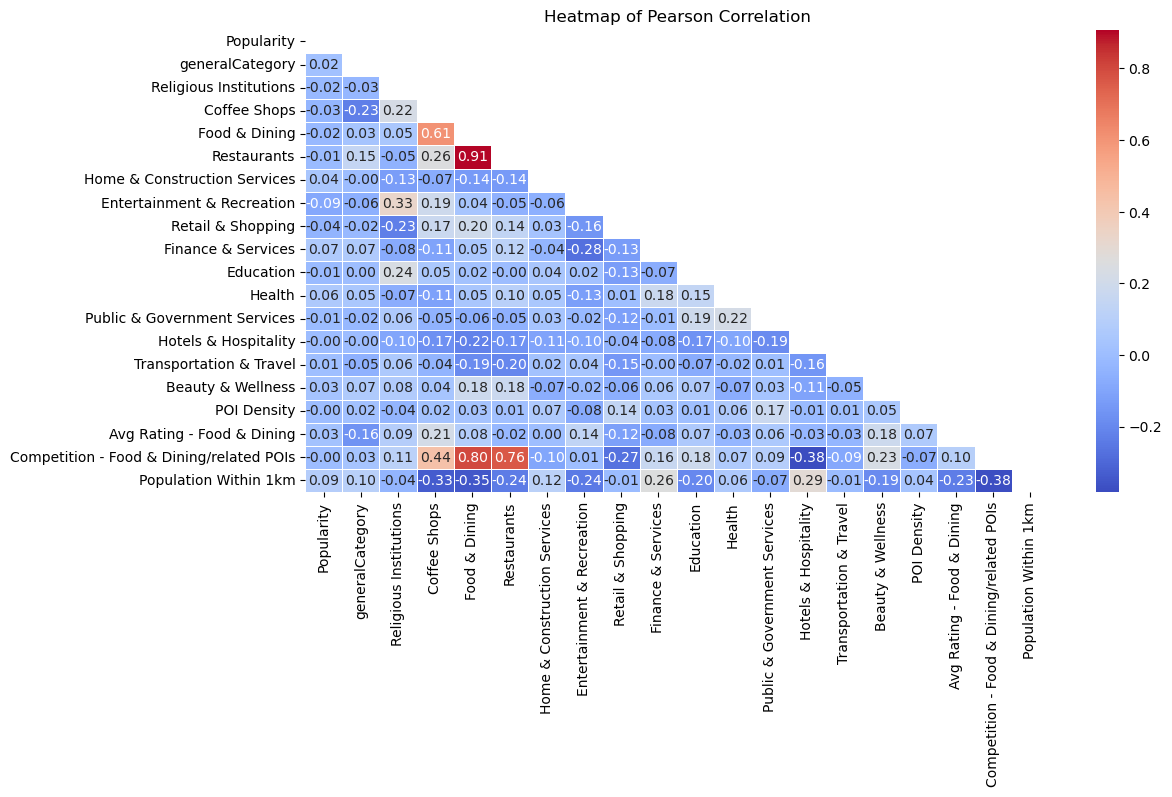

In [21]:
# Compute Pearson correlation
corr_matrix = df.corr()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Heatmap of Pearson Correlation")
plt.show()


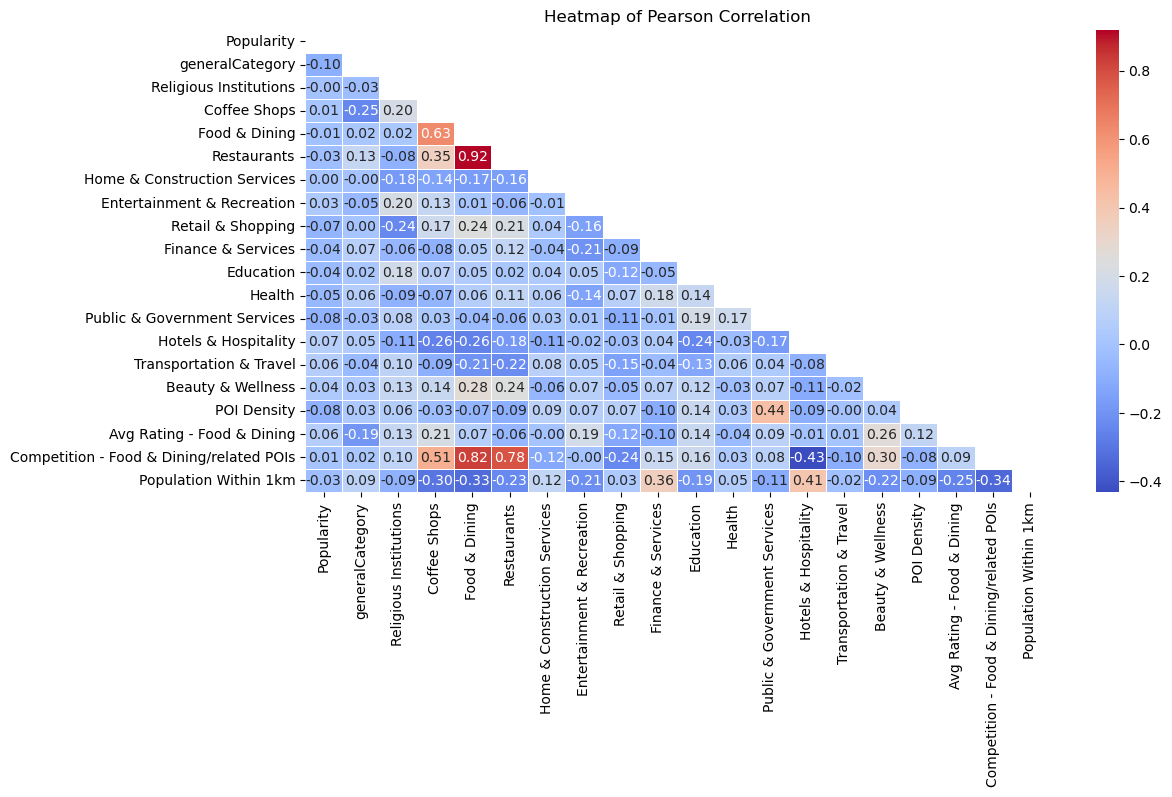

In [22]:
# Compute Pearson correlation for scaled data
corr_matrix = transformed_df.corr()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Heatmap of Pearson Correlation")
plt.show()


### Scatterplots (individual feature vs target) 

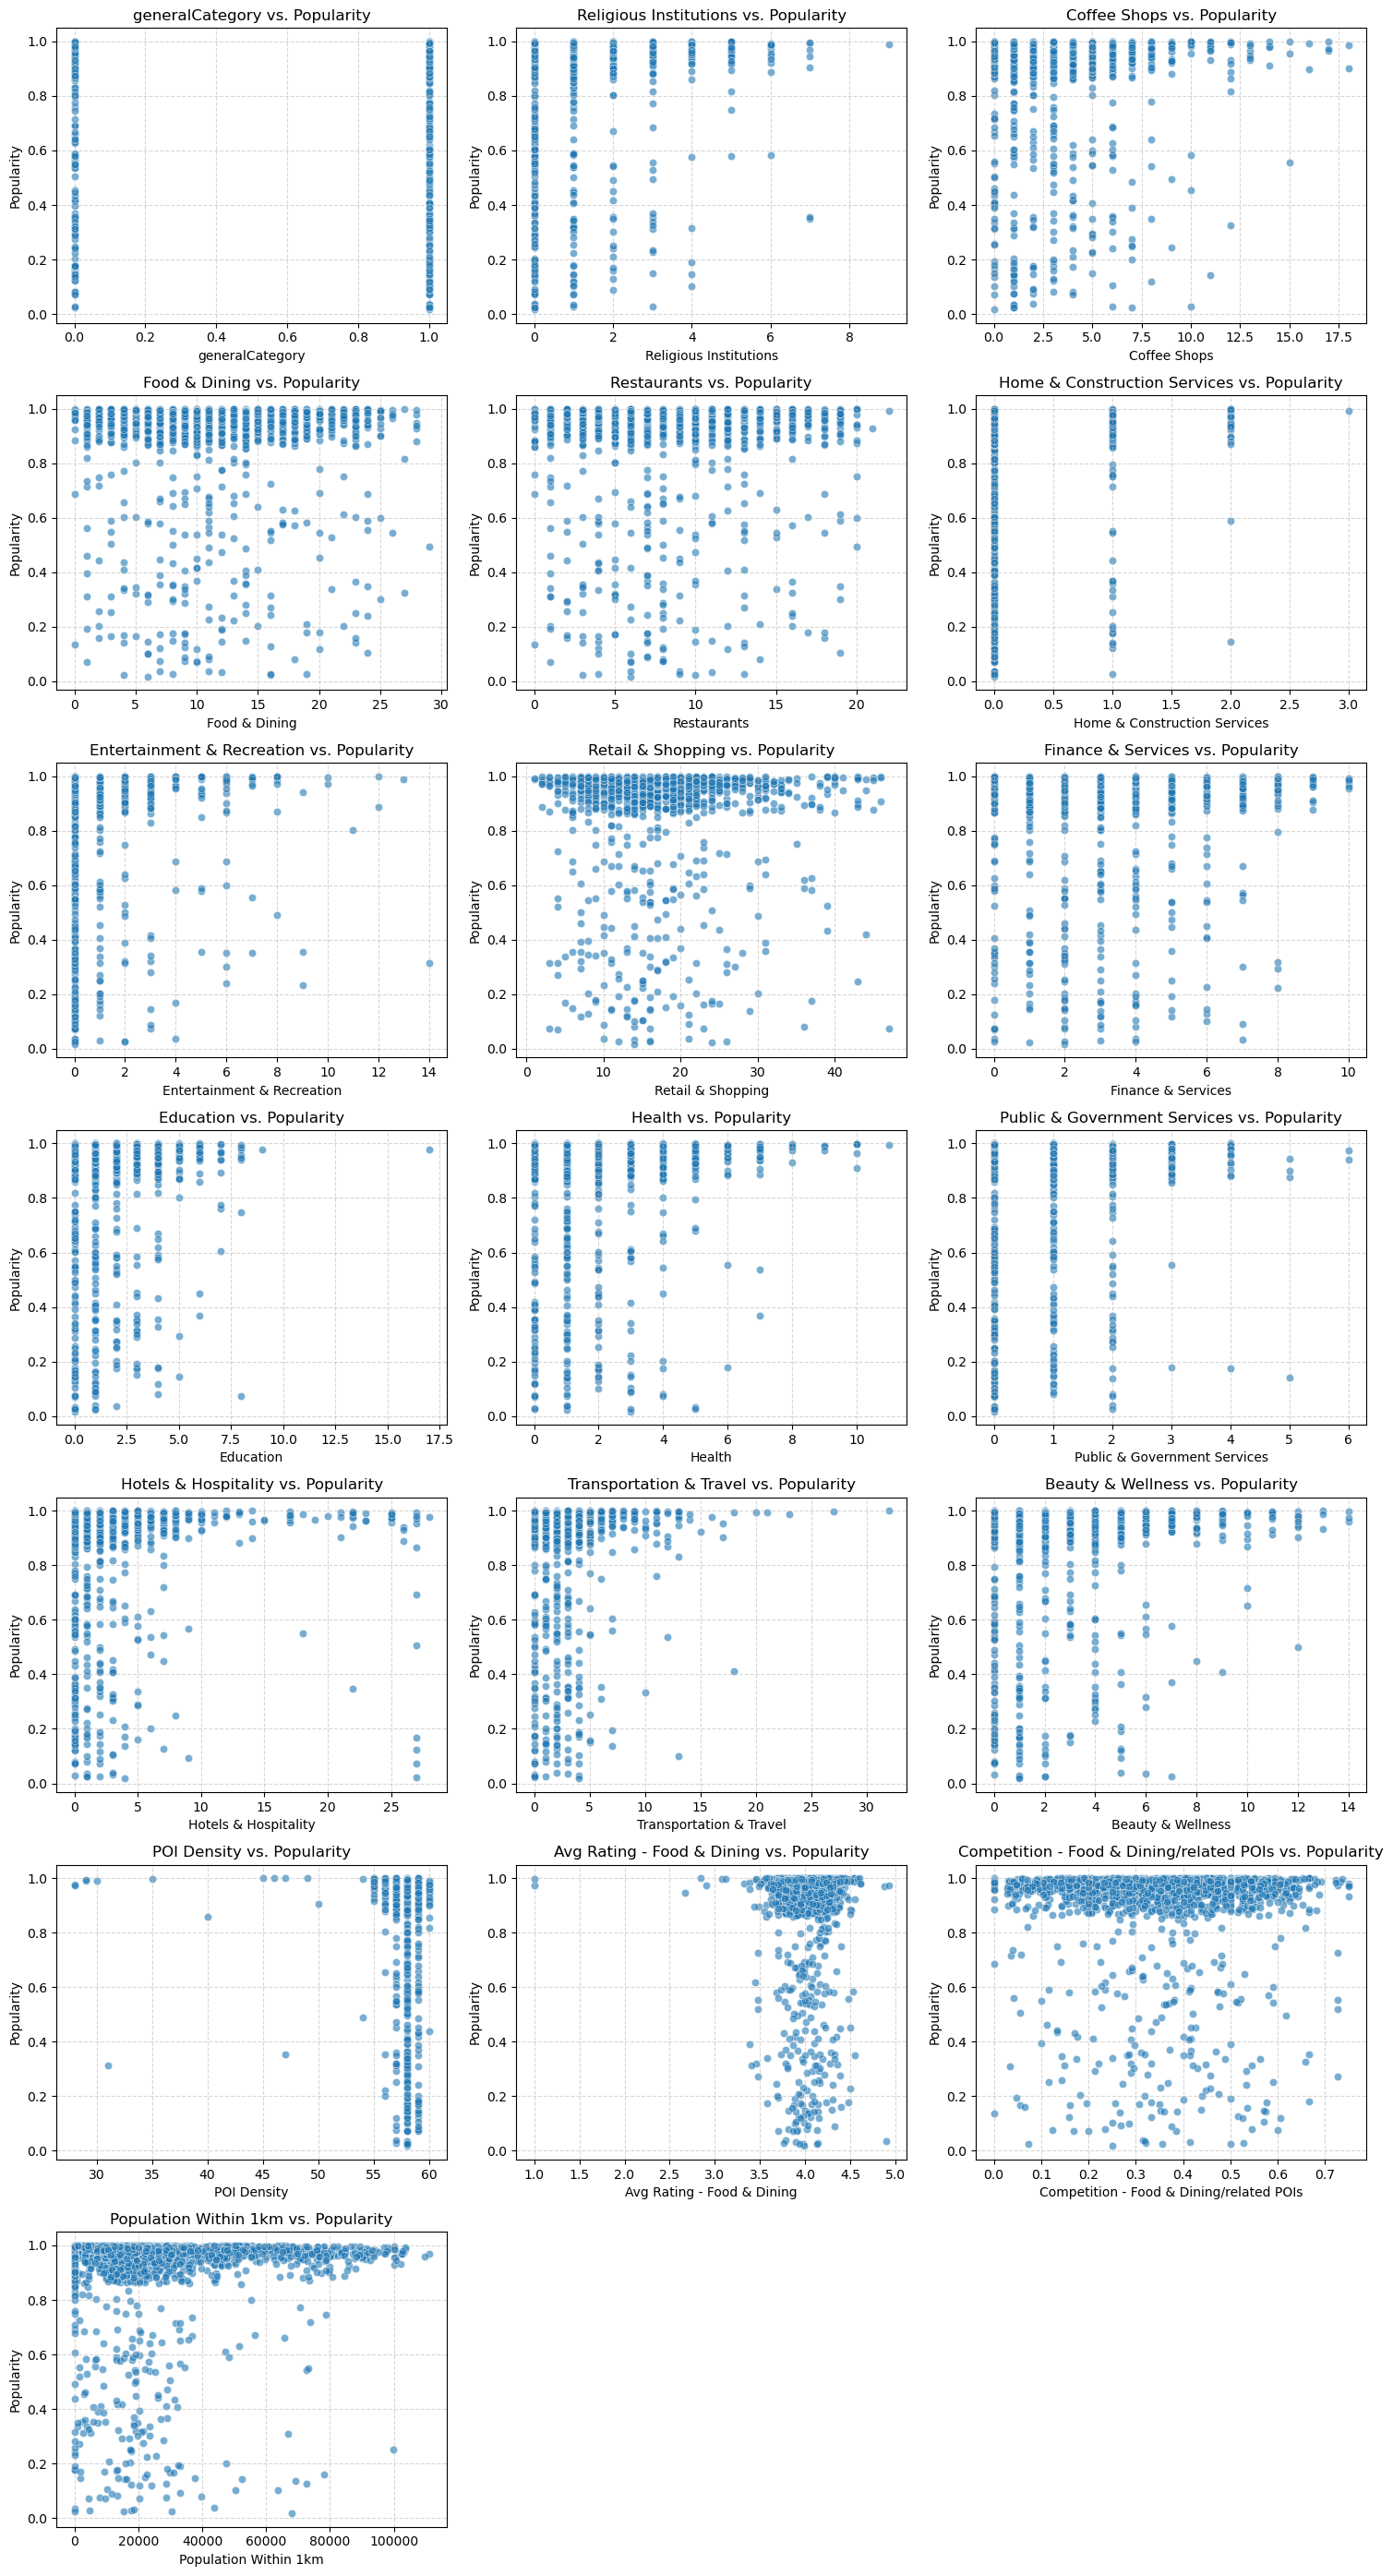

In [24]:
# Original Dataframe (WITHOUT transformation)
# Filter only numeric features (excluding target variable "Popularity")
numeric_features = df.select_dtypes(include=np.number).columns
features_to_plot = [feature for feature in numeric_features if feature != "Popularity"]

# Define grid size
num_features = len(features_to_plot)
num_cols = 3  # Number of columns in the grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Compute required rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through features and create scatter plots
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=df[feature], y=df["Popularity"], alpha=0.6, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Popularity", fontsize=10)
    axes[i].set_title(f"{feature} vs. Popularity", fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.5)

# Remove empty subplots if num_features < num_cols*num_rows
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove unused subplots

# Adjust layout
plt.tight_layout()
plt.show()


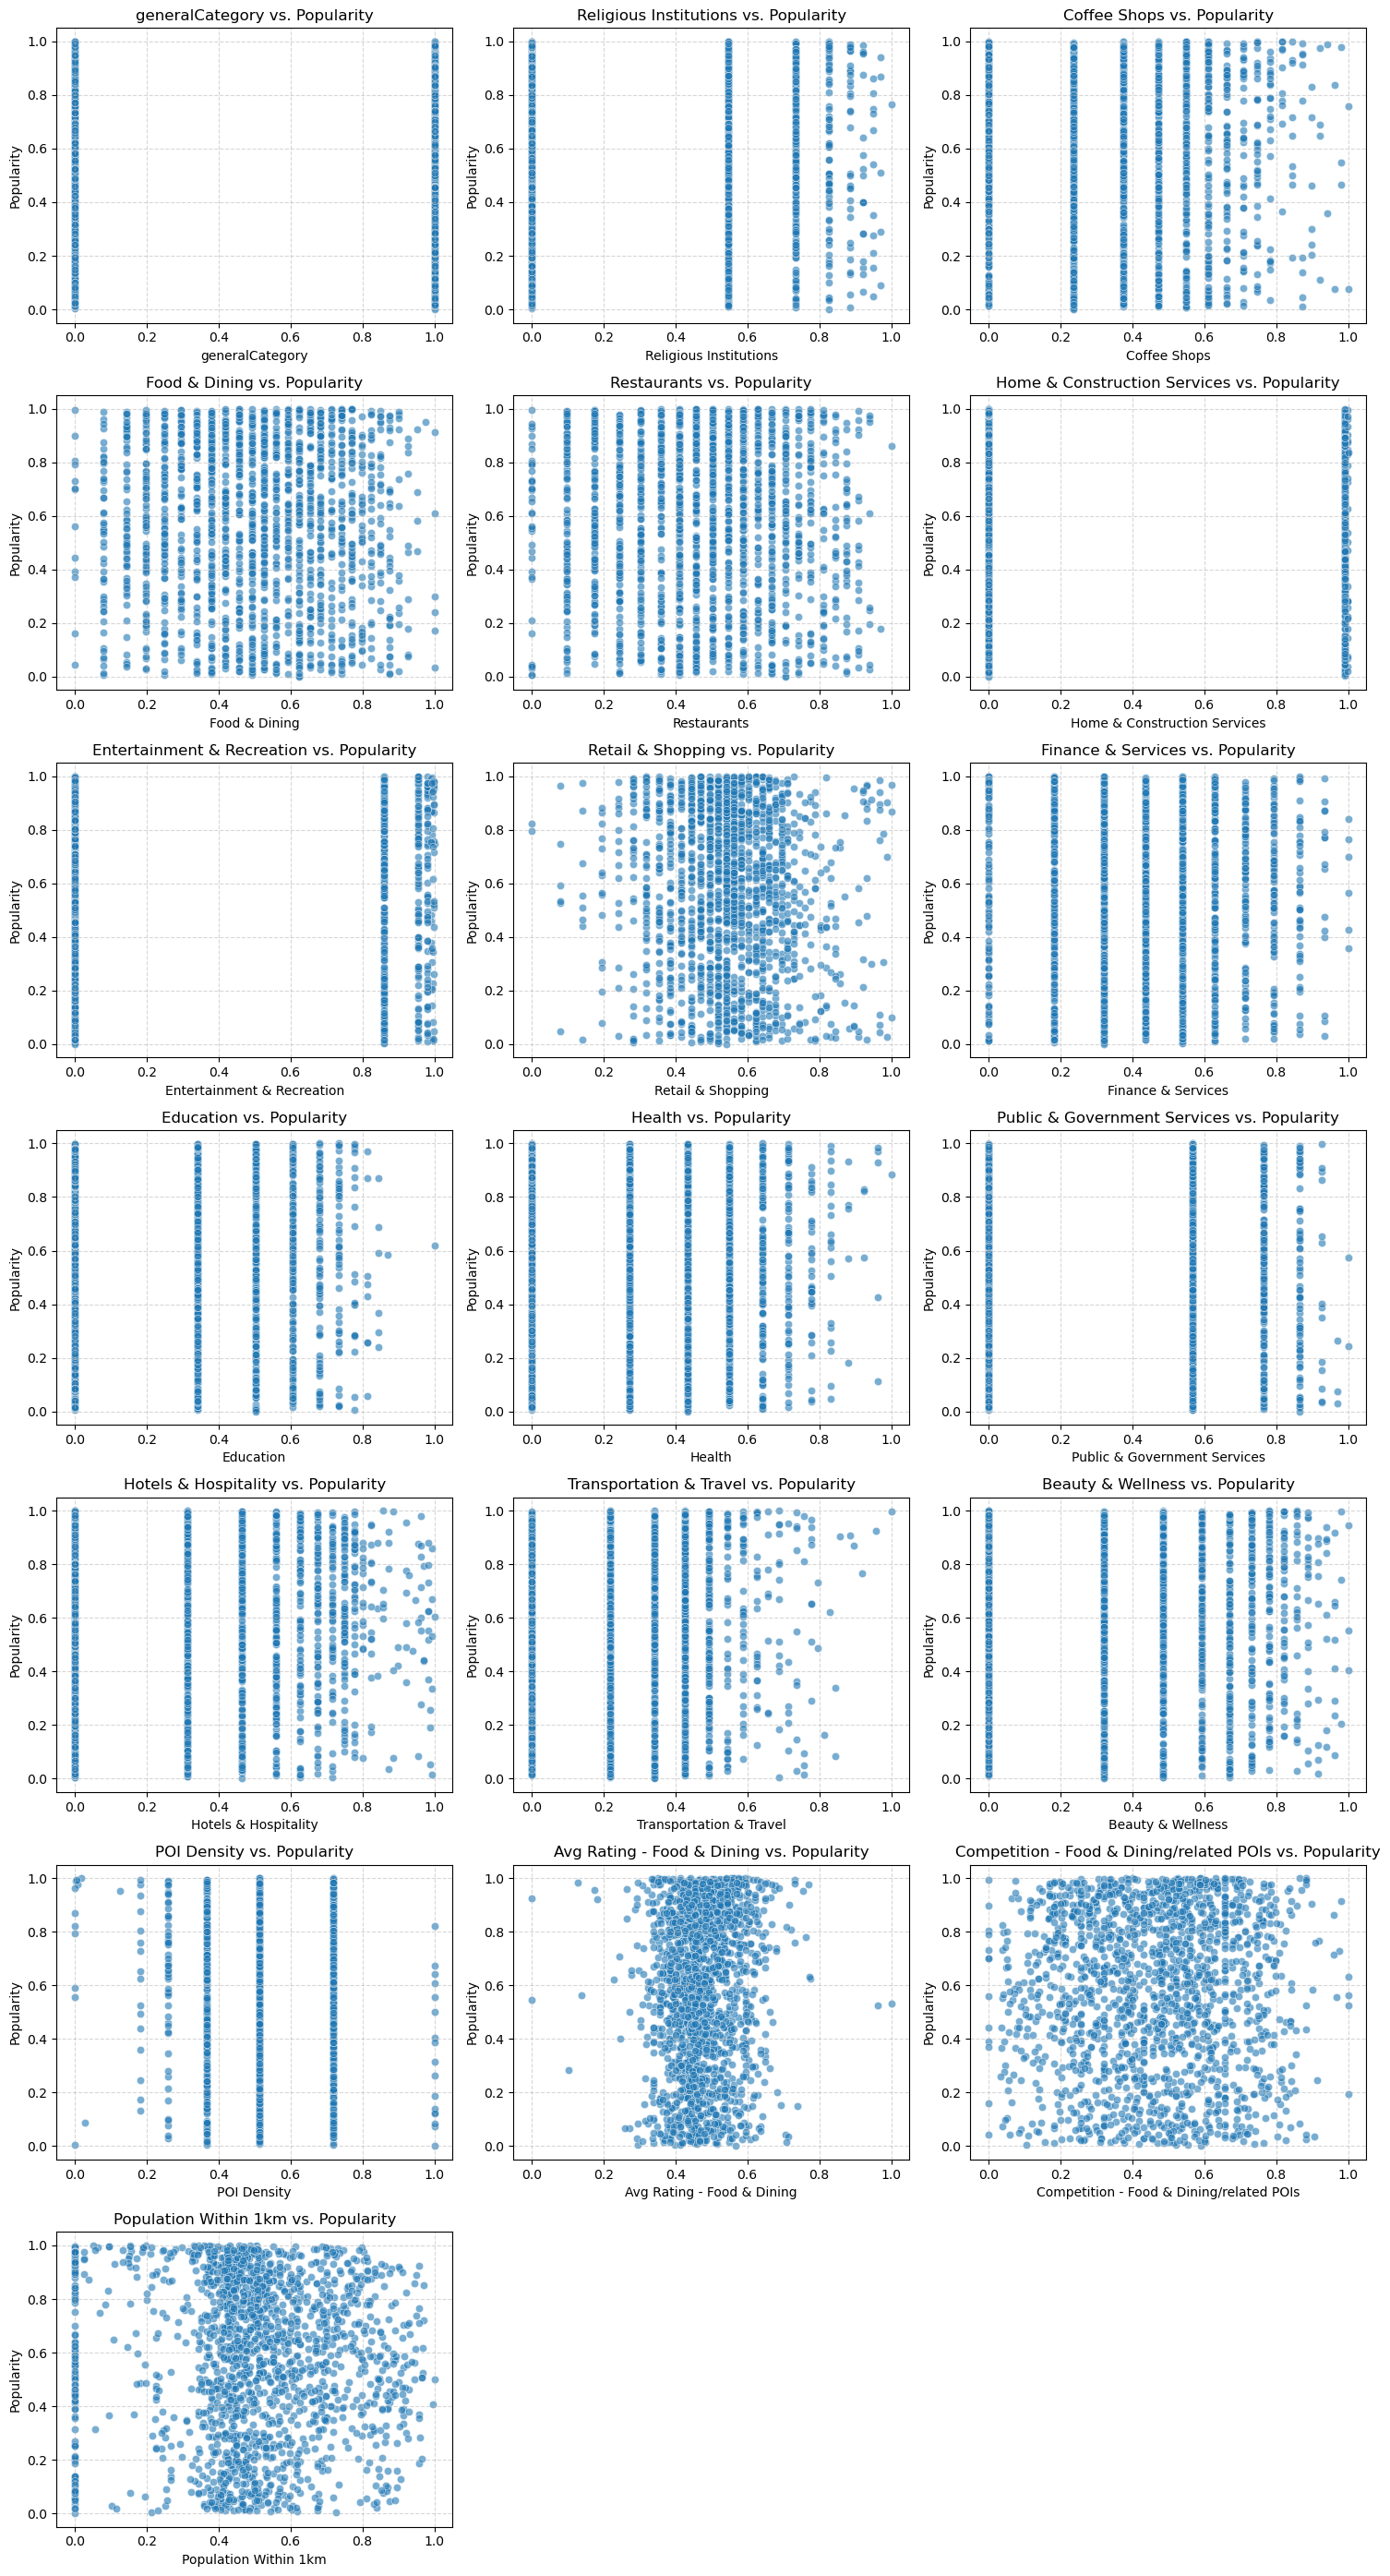

In [25]:
#Scatterplots of Transformed Data
# Filter only numeric features (excluding target variable "Popularity") for transformed data
numeric_features = transformed_df.select_dtypes(include=np.number).columns
features_to_plot = [feature for feature in numeric_features if feature != "Popularity"]

# Define grid size
num_features = len(features_to_plot)
num_cols = 3  # Number of columns in the grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Compute required rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through features and create scatter plots
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=transformed_df[feature], y=transformed_df["Popularity"], alpha=0.6, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Popularity", fontsize=10)
    axes[i].set_title(f"{feature} vs. Popularity", fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.5)

# Remove empty subplots if num_features < num_cols*num_rows
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove unused subplots

# Adjust layout
plt.tight_layout()
plt.show()


## Model Training (Exp.1)

In [27]:
results = []

# Define features (X) and target variable (y)
X = transformed_df.drop(columns=['Popularity'])
y = transformed_df['Popularity']

# Remove Outliers
num_outliers_before = X.shape[0]
X, y = remove_outliers(X, y)
num_outliers_removed = num_outliers_before - X.shape[0]
print(f"Number of data points removed as outliers: {num_outliers_removed}")

# Remove Low Variance Features
#variance_selector = VarianceThreshold(threshold=0.01)
#X_transformed = variance_selector.fit_transform(X)

# Identify removed low-variance features
#removed_low_variance_features = X.columns[~variance_selector.get_support()]
#selected_features = X.columns[variance_selector.get_support()]
#print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

# Convert back to DataFrame with selected features
#X = pd.DataFrame(X_transformed, columns=selected_features)

# Apply function and capture removed features
X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
print(f"Removed highly correlated features: {removed_corr_features}")
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Define parameter grid for tuning

param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split
        "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
        "max_features": ["sqrt", "log2"]  # Number of features to consider per split
    }
    
"""
param_grid = {
        "n_estimators": [129],  # Number of trees
        "max_depth": [1],  # Maximum depth of trees
        "min_samples_split": [11],  # Minimum samples needed to split
        "min_samples_leaf": [4],  # Minimum samples per leaf node
        "max_features": ["log2"]  # Number of features to consider per split
    }
"""
# Perform Grid Search with Cross-Validation (3-fold)
grid_search = GridSearchCV(rf_model, param_grid, scoring="r2", cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Compute evaluation metrics
metrics = {
        "Competition Factor": col,
        "Best Params": grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
}
results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
#print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))


# Compute Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mad = median_abs_deviation(y_test - y_pred)  # Mean Absolute Deviation

print("Best Grid Parameters", grid_search.best_params_) 
# Print Results in Table Format
print(f"{'Metric':<15} │ {'Value':>10}")
print("-" * 35)
print(f"{'RMSE':<15} │ {rmse:>10.6f}")
print(f"{'MSE':<15} │ {mse:>10.6f}")
print(f"{'MAE':<15} │ {mae:>10.6f}")
print(f"{'R²':<15} │ {r2:>10.6f}")
print(f"{'MedAE':<15} │ {medae:>10.6f}")
print(f"{'Max Error':<15} │ {max_err:>10.6f}")
print(f"{'MAD':<15} │ {mad:>10.6f}")

Number of data points removed as outliers: 0
Removed highly correlated features: ['Restaurants']
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Final Metrics Comparison Table:
Best Grid Parameters {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Metric          │      Value
-----------------------------------
RMSE            │   0.286468
MSE             │   0.082064
MAE             │   0.240051
R²              │   0.015513
MedAE           │   0.227970
Max Error       │   0.677117
MAD             │   0.219505


In [28]:
#WITHOUT Grid Search
results = []

# Define features (X) and target variable (y)
X = transformed_df.drop(columns=['Popularity'])
y = transformed_df['Popularity']

# Remove Outliers
num_outliers_before = X.shape[0]
X, y = remove_outliers(X, y)
num_outliers_removed = num_outliers_before - X.shape[0]
print(f"Number of data points removed as outliers: {num_outliers_removed}")

# Remove Low Variance Features
#variance_selector = VarianceThreshold(threshold=0.01)
#X_transformed = variance_selector.fit_transform(X)

# Identify removed low-variance features
#removed_low_variance_features = X.columns[~variance_selector.get_support()]
#selected_features = X.columns[variance_selector.get_support()]
#print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

# Convert back to DataFrame with selected features
#X = pd.DataFrame(X_transformed, columns=selected_features)

# Apply function and capture removed features
X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
print(f"Removed highly correlated features: {removed_corr_features}")
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred = rf_model.predict(X_test)

# Compute evaluation metrics
metrics = {
        "Best Params": grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
}
results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
#print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))

# Compute Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mad = median_abs_deviation(y_test - y_pred)  # Mean Absolute Deviation

# Print Results in Table Format
print(f"{'Metric':<15} │ {'Value':>10}")
print("-" * 35)
print(f"{'RMSE':<15} │ {rmse:>10.6f}")
print(f"{'MSE':<15} │ {mse:>10.6f}")
print(f"{'MAE':<15} │ {mae:>10.6f}")
print(f"{'R²':<15} │ {r2:>10.6f}")
print(f"{'MedAE':<15} │ {medae:>10.6f}")
print(f"{'Max Error':<15} │ {max_err:>10.6f}")
print(f"{'MAD':<15} │ {mad:>10.6f}")

Number of data points removed as outliers: 0
Removed highly correlated features: ['Restaurants']

Final Metrics Comparison Table:
Metric          │      Value
-----------------------------------
RMSE            │   0.305474
MSE             │   0.093314
MAE             │   0.252331
R²              │  -0.119452
MedAE           │   0.221602
Max Error       │   0.810793
MAD             │   0.204750


## Model Training (Exp.2: 4 features only)

In [30]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1709 entries, 0 to 1909
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Popularity                                1709 non-null   float64
 1   generalCategory                           1709 non-null   float64
 2   Religious Institutions                    1709 non-null   float64
 3   Coffee Shops                              1709 non-null   float64
 4   Food & Dining                             1709 non-null   float64
 5   Restaurants                               1709 non-null   float64
 6   Home & Construction Services              1709 non-null   float64
 7   Entertainment & Recreation                1709 non-null   float64
 8   Retail & Shopping                         1709 non-null   float64
 9   Finance & Services                        1709 non-null   float64
 10  Education                                

In [31]:
results = []

# Define features (X) and target variable (y)
X = transformed_df[['POI Density', 'Avg Rating - Food & Dining', 'Competition - Food & Dining/related POIs', 'Population Within 1km']]
y = transformed_df['Popularity']

# Remove Outliers
num_outliers_before = X.shape[0]
X, y = remove_outliers(X, y)
num_outliers_removed = num_outliers_before - X.shape[0]
print(f"Number of data points removed as outliers: {num_outliers_removed}")

# Remove Low Variance Features
#variance_selector = VarianceThreshold(threshold=0.01)
#X_transformed = variance_selector.fit_transform(X)

# Identify removed low-variance features
#removed_low_variance_features = X.columns[~variance_selector.get_support()]
#selected_features = X.columns[variance_selector.get_support()]
#print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

# Convert back to DataFrame with selected features
#X = pd.DataFrame(X_transformed, columns=selected_features)

# Apply function and capture removed features
X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.9)
print(f"Removed highly correlated features: {removed_corr_features}")
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Define parameter grid for tuning

param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split
        "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
        "max_features": ["sqrt", "log2"]  # Number of features to consider per split
    }
    
"""
param_grid = {
        "n_estimators": [129],  # Number of trees
        "max_depth": [1],  # Maximum depth of trees
        "min_samples_split": [11],  # Minimum samples needed to split
        "min_samples_leaf": [4],  # Minimum samples per leaf node
        "max_features": ["log2"]  # Number of features to consider per split
    }
"""
# Perform Grid Search with Cross-Validation (3-fold)
grid_search = GridSearchCV(rf_model, param_grid, scoring="r2", cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Compute evaluation metrics
metrics = {
        "Competition Factor": col,
        "Best Params": grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
}
results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
#print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))


# Compute Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mad = median_abs_deviation(y_test - y_pred)  # Mean Absolute Deviation

print("Best Grid Parameters", grid_search.best_params_) 
# Print Results in Table Format
print(f"{'Metric':<15} │ {'Value':>10}")
print("-" * 35)
print(f"{'RMSE':<15} │ {rmse:>10.6f}")
print(f"{'MSE':<15} │ {mse:>10.6f}")
print(f"{'MAE':<15} │ {mae:>10.6f}")
print(f"{'R²':<15} │ {r2:>10.6f}")
print(f"{'MedAE':<15} │ {medae:>10.6f}")
print(f"{'Max Error':<15} │ {max_err:>10.6f}")
print(f"{'MAD':<15} │ {mad:>10.6f}")

Number of data points removed as outliers: 0
Removed highly correlated features: []
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Final Metrics Comparison Table:
Best Grid Parameters {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Metric          │      Value
-----------------------------------
RMSE            │   0.291211
MSE             │   0.084804
MAE             │   0.245908
R²              │  -0.017356
MedAE           │   0.224509
Max Error       │   0.783166
MAD             │   0.214930


## Model Training for both business types (Without feature scaling)

In [33]:
from scipy.stats import median_abs_deviation

results = []
for col in competition_columns:
    if col not in df.columns:
        continue

    # Define features (X) and target variable (y)
    X = df.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df['Popularity']

    #features included in x
    print(f"\n\nFeatures used for competition factor: '{col}':", list(X.columns))

    # Remove Outliers
    num_outliers_before = X.shape[0]
    X, y = remove_outliers(X, y)
    num_outliers_removed = num_outliers_before - X.shape[0]
    print(f"Number of data points removed as outliers: {num_outliers_removed}")

    # Remove Low Variance Features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_transformed = variance_selector.fit_transform(X)

    # Identify removed low-variance features
    removed_low_variance_features = X.columns[~variance_selector.get_support()]
    selected_features = X.columns[variance_selector.get_support()]
    print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

    # Convert back to DataFrame with selected features
    X = pd.DataFrame(X_transformed, columns=selected_features)

    # Apply function and capture removed features
    #X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.95)
    #print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    metrics = {
        "Competition Factor Used": col,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
    }
    results.append(metrics)


# Display Results for Each Competition Factor
print("\nFinal Metrics Comparison Table:")
print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))




Features used for competition factor: 'Competition - Food & Dining/related POIs': ['generalCategory', 'Religious Institutions', 'Coffee Shops', 'Food & Dining', 'Restaurants', 'Home & Construction Services', 'Entertainment & Recreation', 'Retail & Shopping', 'Finance & Services', 'Education', 'Health', 'Public & Government Services', 'Hotels & Hospitality', 'Transportation & Travel', 'Beauty & Wellness', 'POI Density', 'Avg Rating - Food & Dining', 'Competition - Food & Dining/related POIs', 'Population Within 1km']
Number of data points removed as outliers: 201
Removed low-variance features: []

Final Metrics Comparison Table:
╒══════════════════════════════════════════╤══════════╤══════════╤══════════╤════════════╤══════════╤═════════════╤══════════╕
│ Competition Factor Used                  │     RMSE │      MSE │      MAE │   R² Score │    MedAE │   Max Error │      MAD │
╞══════════════════════════════════════════╪══════════╪══════════╪══════════╪════════════╪══════════╪═══════

## Model Training for both business types (with feature scaling)

In [35]:
#with scaled data
results = []
for col in competition_columns:
    if col not in df_scaled.columns:
        continue

    # Define features (X) and target variable (y)
    X = df_scaled.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df_scaled['Popularity']

    #features included in x
    print(f"\n\nFeatures used for competition factor: '{col}':", list(X.columns))

     # Remove Outliers
    num_outliers_before = X.shape[0]
    X, y = remove_outliers(X, y)
    num_outliers_removed = num_outliers_before - X.shape[0]
    print(f"Number of data points removed as outliers: {num_outliers_removed}")

    # Remove Low Variance Features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_transformed = variance_selector.fit_transform(X)

    # Identify removed low-variance features
    removed_low_variance_features = X.columns[~variance_selector.get_support()]
    selected_features = X.columns[variance_selector.get_support()]
    print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

    # Convert back to DataFrame with selected features
    X = pd.DataFrame(X_transformed, columns=selected_features)

    # Apply function and capture removed features
    #X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.95)
    #print(f"Removed highly correlated features: {removed_corr_features}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    metrics = {
        "Competition Factor Used": col,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
    }
    results.append(metrics)


# Display Results for Each Competition Factor
print("\nFinal Metrics Comparison Table:")
print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))


NameError: name 'df_scaled' is not defined

Literture Results: 
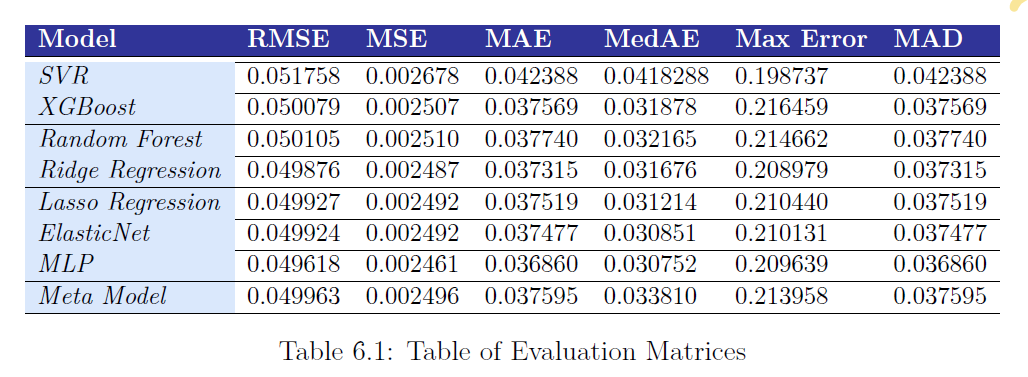

In [ ]:
# Store feature importance results for original data
feature_importance_results = {}

for col in competition_columns:
    if col not in df.columns:
        continue

    # Define features (X) and target variable (y)
    X = df.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df['Popularity']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Store feature importances
    feature_importance_results[col] = model.feature_importances_

# Convert feature importances to a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance_results, index=X.columns)

# Compute mean importance across all competition factors
    feature_importance_df["Mean Importance"] = feature_importance_df.mean(axis=1)

# Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by="Mean Importance", ascending=False)

# Display feature importance table
    print("\nFeature Importance Table:")
    print(feature_importance_df[["Mean Importance"]])  # Display top 20 features

# Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance_df["Mean Importance"].plot(kind="bar", color="royalblue", edgecolor="black")
    plt.title("Feature Importances (Mean Across Models)")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


## Applying Grid search

In [ ]:
results = []

for col in competition_columns:
    if col not in df.columns:
        continue

    # Define features (X) and target variable (y)
    X = df.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df['Popularity']

     # Remove Outliers
    num_outliers_before = X.shape[0]
    X, y = remove_outliers(X, y)
    num_outliers_removed = num_outliers_before - X.shape[0]
    print(f"Number of data points removed as outliers: {num_outliers_removed}")

    # Remove Low Variance Features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_transformed = variance_selector.fit_transform(X)

    # Identify removed low-variance features
    removed_low_variance_features = X.columns[~variance_selector.get_support()]
    selected_features = X.columns[variance_selector.get_support()]
    print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

    # Convert back to DataFrame with selected features
    X = pd.DataFrame(X_transformed, columns=selected_features)

    # Apply function and capture removed features
    #X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.95)
    #print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=42)

    # Define parameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split
        "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
        "max_features": ["sqrt", "log2"]  # Number of features to consider per split
    }


    # Perform Grid Search with Cross-Validation (3-fold)
    grid_search = GridSearchCV(rf_model, param_grid, scoring="r2", cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Make predictions using the best model
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Compute evaluation metrics
    metrics = {
        "Competition Factor": col,
        "Best Params": grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
    }
    results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))

In [ ]:
results = []

for col in competition_columns:
    if col not in df_scaled.columns:
        continue

    # Define features (X) and target variable (y)
    X = df_scaled.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df_scaled['Popularity']

    # Remove Outliers
    num_outliers_before = X.shape[0]
    X, y = remove_outliers(X, y)
    num_outliers_removed = num_outliers_before - X.shape[0]
    print(f"Number of data points removed as outliers: {num_outliers_removed}")

    # Remove Low Variance Features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_transformed = variance_selector.fit_transform(X)

    # Identify removed low-variance features
    removed_low_variance_features = X.columns[~variance_selector.get_support()]
    selected_features = X.columns[variance_selector.get_support()]
    print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

    # Convert back to DataFrame with selected features
    X = pd.DataFrame(X_transformed, columns=selected_features)

    # Apply function and capture removed features
    #X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.95)
    #print(f"Removed highly correlated features: {removed_corr_features}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=42)

    # Define parameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split
        "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
        "max_features": ["sqrt", "log2"]  # Number of features to consider per split
    }


    # Perform Grid Search with Cross-Validation (5-fold)
    grid_search = GridSearchCV(rf_model, param_grid, scoring="r2", cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Make predictions using the best model
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Compute evaluation metrics
    metrics = {
        "Competition Factor": col,
        "Best Params": grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
    }
    results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error
from scipy.stats import median_abs_deviation
import numpy as np
from tabulate import tabulate

results = []

for col in competition_columns:
    if col not in df.columns:
        continue

    # Define features (X) and target variable (y)
    X = df.drop(columns=['Popularity'] + [c for c in competition_columns if c != col], errors='ignore')
    y = df['Popularity']

        # Remove Outliers
    num_outliers_before = X.shape[0]
    X, y = remove_outliers(X, y)
    num_outliers_removed = num_outliers_before - X.shape[0]
    print(f"Number of data points removed as outliers: {num_outliers_removed}")

    # Remove Low Variance Features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_transformed = variance_selector.fit_transform(X)

    # Identify removed low-variance features
    removed_low_variance_features = X.columns[~variance_selector.get_support()]
    selected_features = X.columns[variance_selector.get_support()]
    print(f"Removed low-variance features: {removed_low_variance_features.tolist()}")

    # Convert back to DataFrame with selected features
    X = pd.DataFrame(X_transformed, columns=selected_features)

    # Apply function and capture removed features
    #X, removed_corr_features = remove_highly_correlated_features(X, threshold=0.95)
    #print(f"Removed highly correlated features: {removed_corr_features}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=42)

    # Define parameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split
        "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
        "max_features": ["sqrt", "log2"]  # Number of features to consider per split
    }

    # Perform Grid Search with Cross-Validation (5-fold)
    grid_search = GridSearchCV(rf_model, param_grid, scoring="r2", cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best R² score from cross-validation
    best_r2_score = grid_search.best_score_

    # Make predictions using the best model
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    # Compute evaluation metrics
    test_r2_score = r2_score(y_test, y_pred)

    metrics = {
        "Competition Factor": col,
        "Best Params": grid_search.best_params_,
        "Best R² Score (CV)": best_r2_score,  # Best R² from training cross-validation
        "Test R² Score": test_r2_score,  # R² on test data
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Max Error": max_error(y_test, y_pred),
        "MAD": median_abs_deviation(y_test - y_pred)
    }
    results.append(metrics)

# Display results in a table
print("\nFinal Metrics Comparison Table:")
print(tabulate(results, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))


## Target Variable Analysis

In [ ]:
y = df['Popularity']
y.var()

In [ ]:
y2 = df_scaled['Popularity']
y2.var()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True, color='royalblue')

plt.title("Distribution of Target Variable (y)")
plt.xlabel("Popularity Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

y_filtered = y[(y >= lower_bound) & (y <= upper_bound)]
y_filtered.var()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y_filtered, bins=30, kde=True, color='royalblue')

plt.title("Distribution of Target Variable (y)")
plt.xlabel("Popularity Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y, color='orange')

plt.title("Box Plot of Target Variable (y)")
plt.xlabel("Popularity Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
